# Infinite-$n$ ideal ballooning stability optimization

<font size="4">
This tutorial demonstrates how to evaluate and optimize an equilibrium for infinite-$n$ ideal-ballooning stability with DESC.
The infinite-$n$ ideal ballooning equation is

$$
\mathbf{B} \cdot \nabla \left( \frac{|\nabla \alpha|^2}{B^2} \mathbf{B} \cdot \nabla X \right) + 2 \frac{d \mu_0 p}{d\psi} \left[\mathbf{B} \times (\mathbf{b} \cdot \nabla \mathbf{b})\right] \cdot \nabla \alpha\, X = \lambda \frac{|\nabla \alpha|^2}{B^2} X, \quad \lambda = -\omega^2
$$

where $X$ is the ballooning eigenfunction whereas $\lambda$ is the ballooning eigenvalue. When $\lambda > 0$, the mode is ballooning-unstable, otherwise it is ballooning-stable. The equation is solved subject to Dirichlet boundary conditions on the eigenfunction $X$

$$X(\zeta = \zeta_1) = 0, X(\zeta = \zeta_2) = 0$$

where $\zeta_1$ and $\zeta_2$ are endpoints of the domain in ballooning space (a transformed covering space where $\zeta \in [0, 2\pi]$ to $\zeta \in [-\infty, \infty]$). Note that the ballooning $\zeta$ is technically a different coordinate than periodic $\zeta$

Numerically, this equation becomes a 1D EVP (eigenvalue problem) along a field line. 

$$ \frac{d}{d\zeta} \left(g \frac{dX}{d\zeta} \right) + c X = \lambda f X$$

where 

$$
\begin{eqnarray}
    \text{g} &=& (\mathbf{b} \cdot \nabla \zeta) \frac{|\nabla \alpha|^2}{B}, \\
    \text{c} &=& \frac{1}{B^2} \frac{d(\mu_0 p)}{d\psi} \frac{2}{(\mathbf{b} \cdot \nabla \zeta)} (\mathbf{b} \times (\mathbf{b} \cdot \nabla \mathbf{b})) \times \nabla \alpha, \\
    \text{f} &=& \frac{1}{(\mathbf{b} \cdot \nabla \zeta)} \frac{|\nabla \alpha|^2}{B^3},
\end{eqnarray}
$$

are functions of $\zeta$ along a field line.
</font>

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

If you have access to a GPU, uncomment the following two lines. 

In [2]:
# from desc import set_device
# set_device("gpu")

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from desc.vmec import VMECIO

from desc.backend import jnp
from desc.equilibrium import Equilibrium
from desc.equilibrium.coords import compute_theta_coords
from desc.geometry import FourierRZToroidalSurface
from desc.grid import LinearGrid, Grid
from desc.optimize import Optimizer
from desc.objectives import (
    ForceBalance,
    AspectRatio,
    FixIota,
    FixPressure,
    FixPsi,
    GenericObjective,
    BallooningStability,
    ObjectiveFunction,
    FixBoundaryR,
    FixBoundaryZ,
)
from desc.plotting import *

plt.rcParams["font.size"] = 14

DESC version 0.9.0+4957.g7a5b3dc6.dirty,using JAX backend, jax version=0.4.27, jaxlib version=0.4.27, dtype=float64
Using device: CPU, with 23.43 GB available memory


# Evaluating ballooning stability of the initial equilibrium

<font size="4">
In this section, we will show how you can take a DESC or VMEC equilibrium and evaluate its ballooning stability using DESC
You have to specify the normalized distance $\rho$ and the field line label $\alpha$ on which you want to solve the ballooning equation. 

DESC will solve the ballooning equation on multiple field lines on each flux surface and output the maximum ballooning growth rate on each flux surface. 

$$ \lambda_{\rho, \mathrm{max}} = \mathrm{max}_{\alpha}(\lambda_{\rho, \alpha}), \quad \forall \quad \alpha \in [0, \pi]$$
</font>

In [11]:
# Importing the HELIOTRON VMEC equilibrium
#eq = VMECIO.load("../../../tests/inputs/wout_HELIOTRON.nc")

# Importing the HELIOTRON DESC equilibrium
eq = Equilibrium.load("../../../desc/examples/HELIOTRON_output.h5")[-1]

#eq = Equilibrium.load("../../../desc/examples/NCSX_output.h5")[-1]

## It is not necessary (but often useful) to re-solve your equilibrium to ensure that the force error is small
#eq, _ = eq.solve(objective="force", verbose=3)

(<Figure size 2161.06x1440.71 with 12 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Ax

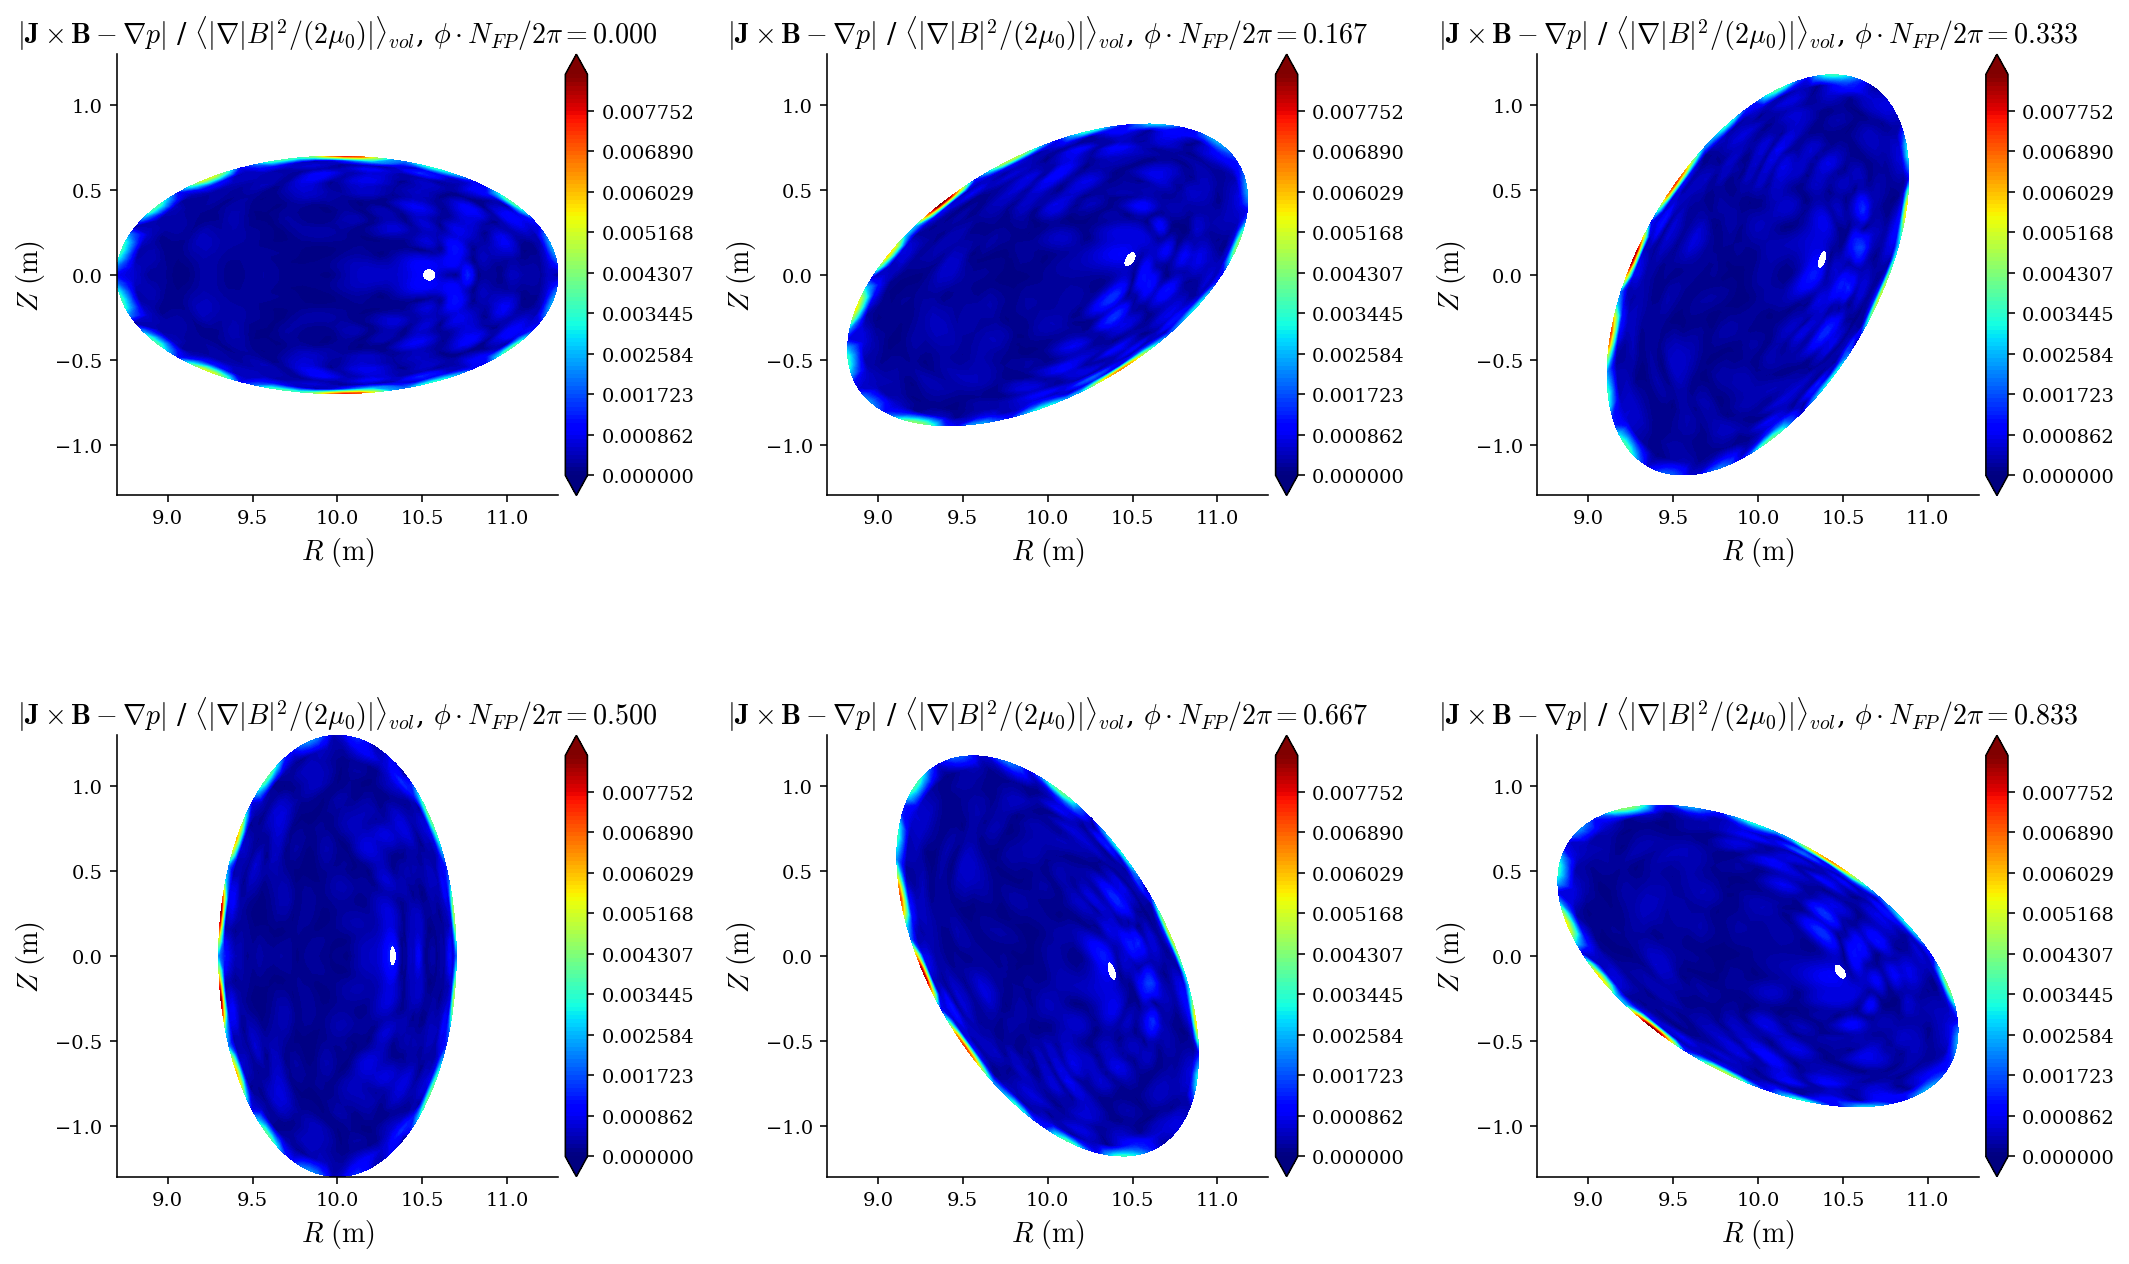

In [12]:
plot_section(eq, name="|F|", norm_F=True)

In [13]:
# Copying the equilibrium object
eq0 = eq.copy()

#Flux surfaces on which to evaluate ballooning stability
surfaces = [0.01, 0.4, 0.6, 0.8, 1.0]

grid = LinearGrid(rho = jnp.array(surfaces), NFP=eq0.NFP)
eq_data_keys = ["iota"]

data = eq0.compute(eq_data_keys, grid=grid)
iota = data["iota"]

Nalpha = int(8) # Number of field lines

# Field lines on which to evaluate ballooning stability
alpha = jnp.linspace(0, np.pi, Nalpha+1)[:Nalpha]

# Number of toroidal transits of the field line 
ntor = int(3)

# Number of point along a field line in ballooning space
N0 = int(1. * ntor * eq0.M_grid * eq0.N_grid + 1)

# range of the ballooning coordinate zeta
zeta = np.linspace(-jnp.pi*ntor, jnp.pi*ntor, N0)

gamma_max0 = np.zeros(len(surfaces), )
theta_PEST = np.zeros((N0*Nalpha,))
zeta_full = np.zeros((N0*Nalpha, ))

for j in range(len(surfaces)):
    rho = surfaces[j]*np.ones((N0*Nalpha, ))
    
    for i in range(Nalpha): 
        theta_PEST[N0*i:N0*(i+1)] = alpha[i] + iota[j] * zeta
        zeta_full[N0*i:N0*(i+1)] = zeta
        
    theta_coords = jnp.array([rho, theta_PEST, zeta_full]).T

    
    # Rootfinding theta for a given theta_PEST
    desc_coords = compute_theta_coords(
        eq0, theta_coords, L_lmn=eq.L_lmn, tol=1e-8, maxiter=25
    )

    sfl_grid = Grid(desc_coords, sort=False)
    ball_data0 = eq0.compute(["ideal_ball_gamma2"], grid=sfl_grid)    

    gamma_max0[j] = np.max(ball_data0["ideal_ball_gamma2"])
    print(f"surf number {j} done!")

print("Growth rate calculation finished!")

surf number 0 done!
surf number 1 done!
surf number 2 done!
surf number 3 done!
surf number 4 done!
Growth rate calculation finished!


## Plotting the maximum ballooning growth rate

<font size="4">
After finishing an optimization, we plot the maximum ballooning growth rate $\lambda_{\mathrm{max}}$ on the chosen flux surfaces
</font>

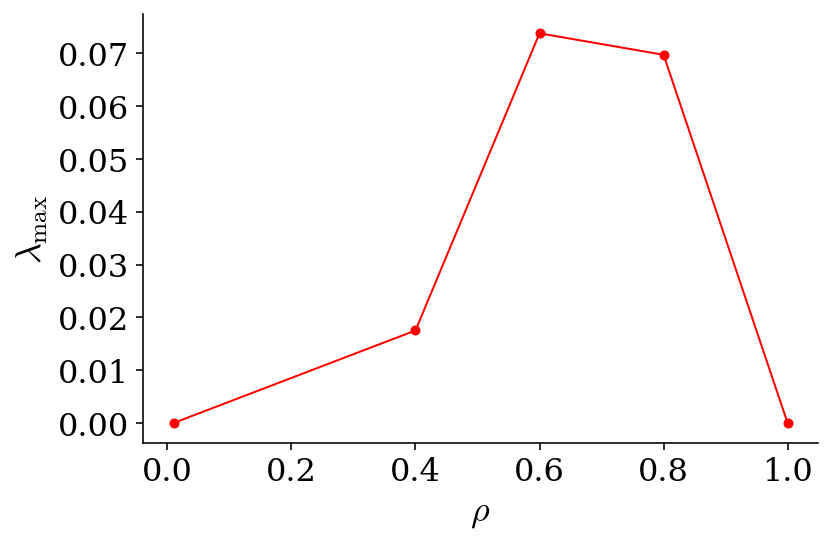

In [14]:
plt.plot(np.array(surfaces), gamma_max0, '-or', ms=4);
plt.xlabel(r"$\rho$", fontsize=18);
plt.ylabel(r"$\lambda_{\mathrm{max}}$", fontsize=18);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

<font size="4">
Note that the ballooning instability is driven by a pressure gradient. In the edge, if $p = 0$ but $dp/d\rho \neq 0$, we can still have a finite ballooning growth rate.
As a corollary, for vacuum equilibria or on equilibria with $dp/d\rho = 0$, the ballooning growth rate $\lambda <= 0$
</font>

## Newcomb's metric: A faster proxy for ballooning stability

<font size="4">
To expedite the stability calculation even further, we can use the Newcomb metric instead. It uses the Slurm oscillation theorem to determine whether an equilibrium is stable or unstable. However, the growth rate information or eigenfunction information is not calculated.
But since the calculation is faster than an eigenvalue solve, we can determine the stability of an equilibrium.
</font>

In [8]:
# Copying the equilibrium object
eq0 = eq.copy()

#Flux surfaces on which to evaluate ballooning stability
surfaces = [0.01, 0.4, 0.6, 0.8, 1.0]

grid = LinearGrid(rho = jnp.array(surfaces), NFP=eq0.NFP)
eq_data_keys = ["iota"]

data = eq0.compute(eq_data_keys, grid=grid)
iota = data["iota"]

Nalpha = int(8) # Number of field lines

# Field lines on which to evaluate ballooning stability
alpha = jnp.linspace(0, np.pi, Nalpha+1)[:Nalpha]

# Number of toroidal transits of the field line 
ntor = int(3)

# Number of point along a field line in ballooning space
N0 = int(1. * ntor * eq0.M_grid * eq0.N_grid + 1)

# range of the ballooning coordinate zeta
zeta = np.linspace(-jnp.pi*ntor, jnp.pi*ntor, N0)

Newcomb_metric0 = np.zeros(len(surfaces), )
theta_PEST = np.zeros((N0*Nalpha,))
zeta_full = np.zeros((N0*Nalpha, ))

for j in range(len(surfaces)):
    rho = surfaces[j]*np.ones((N0*Nalpha, ))
    
    for i in range(Nalpha): 
        theta_PEST[N0*i:N0*(i+1)] = alpha[i] + iota[j] * zeta
        zeta_full[N0*i:N0*(i+1)] = zeta
        
    theta_coords = jnp.array([rho, theta_PEST, zeta_full]).T

    
    # Rootfinding theta for a given theta_PEST
    desc_coords = compute_theta_coords(
        eq0, theta_coords, L_lmn=eq.L_lmn, tol=1e-8, maxiter=25
    )

    sfl_grid = Grid(desc_coords, sort=False)
    ball_data0 = eq0.compute(["Newcomb_metric"], grid=sfl_grid)    

    Newcomb_metric0[j] = np.max(ball_data0["Newcomb_metric"])
    print(f"surf number {j} done!")

print("Newcomb metric calculation finished!")

surf number 0 done!
surf number 1 done!
surf number 2 done!
surf number 3 done!
surf number 4 done!
Newcomb metric calculation finished!


## Plotting the Newcomb metric

<font size="4">
A newcomb metric value greater than one implies instability whereas any value less than one implies stability.
</font>

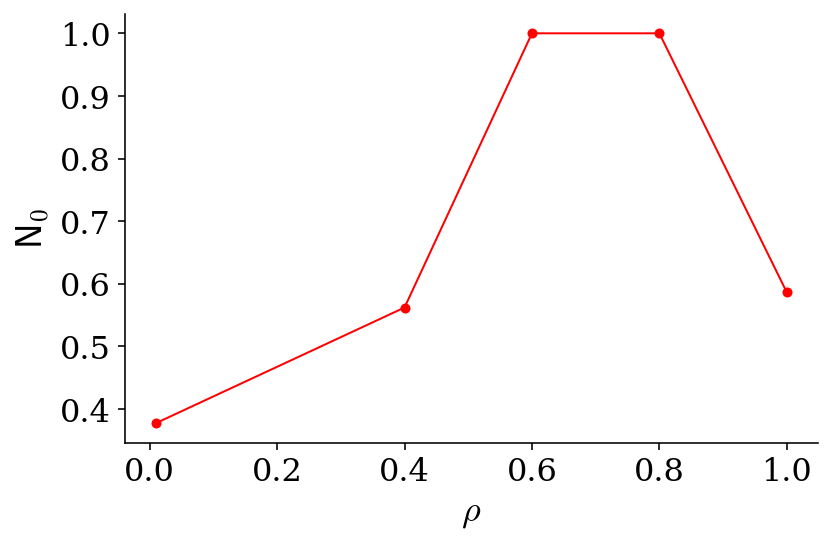

In [9]:
plt.plot(np.array(surfaces), Newcomb_metric0, '-or', ms=4);
plt.xlabel(r"$\rho$", fontsize=18);
plt.ylabel(r"$\mathsf{N}_0$", fontsize=18);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

# Optimizing for ballooning stability

Next, we explain how to take an existing ballooning unstable equilibirum and optimize it for ideal ballooning stability using DESC. The process is similar to other tutorials where you add the ballooning objective to the list of objective functions.

In [55]:
# Flux surfaces on which to evaluate ballooning stability
surfaces_ball = [0.8]

Nalpha = int(8) # Number of field lines

# Field lines on which to evaluate ballooning stability
alpha = jnp.linspace(0, np.pi, Nalpha+1)[:Nalpha]

# Number of toroidal transits of the field line 
ntor = int(3)

# Number of point along a field line in ballooning space
N0 = int(1. * ntor * eq.M_grid * eq.N_grid + 1)

# Determine which modes to unfix
k = 2

print("\n---------------------------------------")
print(f"Optimizing boundary modes M, N <= {k}")
print("---------------------------------------")

objs_ball = {}

eq_ball_weight = 1.0e2

for i, rho in enumerate(surfaces_ball):
    shift_arr = np.random.default_rng().uniform(-0.1, 0.1, Nalpha-1)
    alpha = np.reshape(np.linspace(0, np.pi, Nalpha+1)[:Nalpha], (-1, 1))
    alpha[1:, :] = alpha[1:, :] + np.reshape(shift_arr, (-1, 1))

    objs_ball[rho] = BallooningStability(eq=eq,rho=np.array([rho]), alpha=alpha, zetamax=ntor*jnp.pi, nzeta=N0, weight=eq_ball_weight)

Curvature_grid = LinearGrid(M = 2*int(eq.M), N = 2*int(eq.N), rho=np.array([1.0]), NFP=eq.NFP, sym=True, axis=False)

modes_R = np.vstack(
    (
        [0, 0, 0],
        eq.surface.R_basis.modes[
            np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :
        ],
    )
)
modes_Z = eq.surface.Z_basis.modes[
    np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :
]


objective = ObjectiveFunction((AspectRatio(eq=eq, bounds=(8.9, 9.7), weight=8e3),
                               GenericObjective(f="curvature_k2_rho", thing=eq, grid=Curvature_grid, bounds=(-80, 10), weight=2e3),)
                               + tuple(objs_ball.values()))

constraints = (
        ForceBalance(eq=eq),
        FixBoundaryR(eq=eq, modes=modes_R),
        FixBoundaryZ(eq=eq, modes=modes_Z),
        FixPressure(eq=eq),
        FixIota(eq=eq),
        FixPsi(eq=eq),
        )

optimizer = Optimizer("proximal-lsq-exact")
(eq,), _ = optimizer.optimize(
            eq,
            objective,
            constraints,
            ftol=1e-4, 
            xtol=1e-6,
            gtol=1e-6,
            maxiter=5,  # increase maxiter to 50 for a better result
            verbose=3,
            options={"initial_trust_ratio":2e-3},
            )
print("Optimization complete!")


---------------------------------------
Optimizing boundary modes M, N <= 2
---------------------------------------
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 67.5 ms
Building objective: generic
Building objective: ideal-ball gamma
Timer: Objective build = 250 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 85.5 ms
Timer: Objective build = 276 ms
Timer: Proximal projection build = 2.92 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed Psi
Timer: Objective build = 802 ms
Timer: Linear constraint projection build = 885 ms
Number of parameters: 24
Number of objectives: 327
Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.947e+07                                    2.874e+08   


(<Figure size 1728.85x1440.71 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

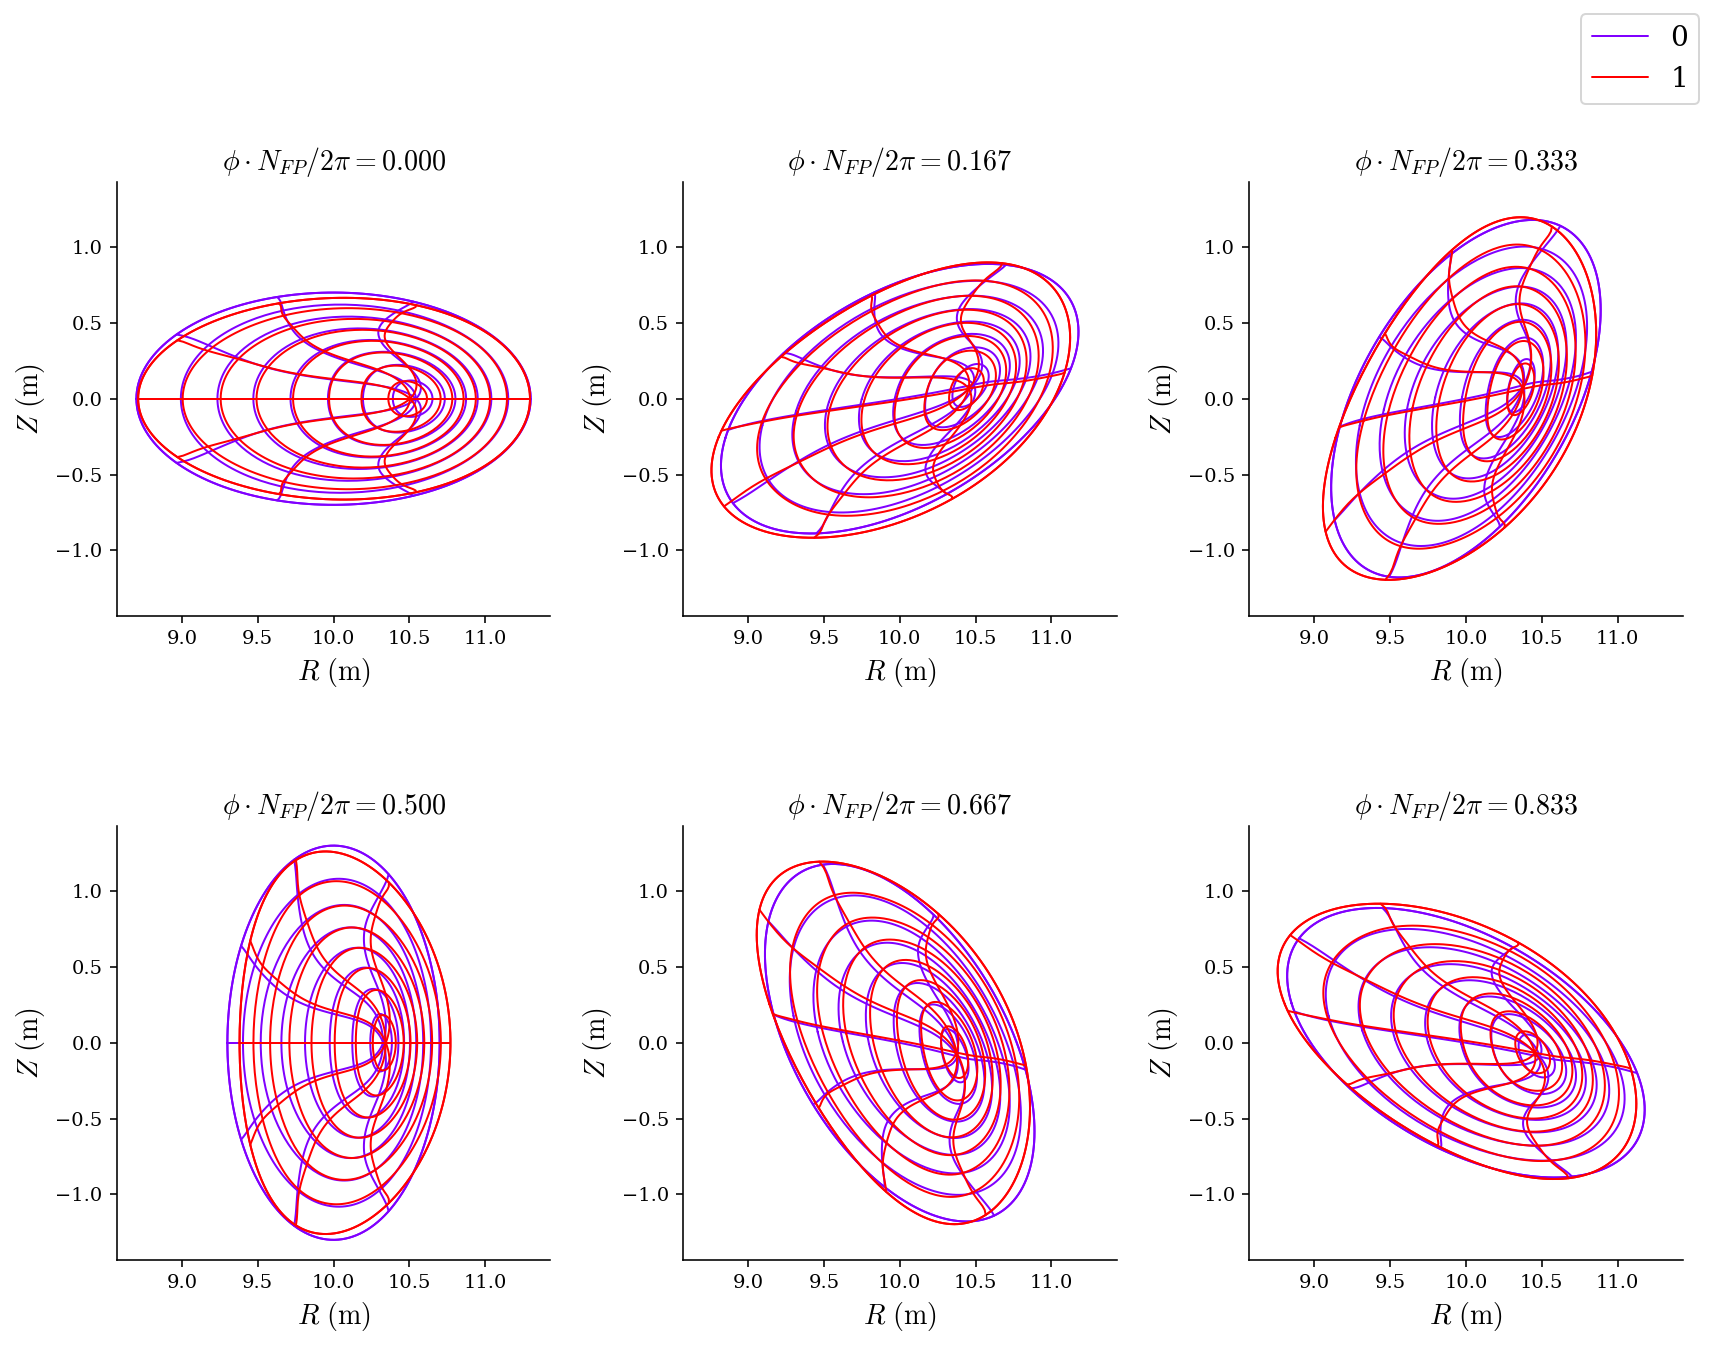

In [56]:
plot_comparison([eq0, eq])

# Comparing growth rates of the initial and optimized equilibria

surf number 0 done!
surf number 1 done!
surf number 2 done!
surf number 3 done!
surf number 4 done!
Growth rate calculation finished!


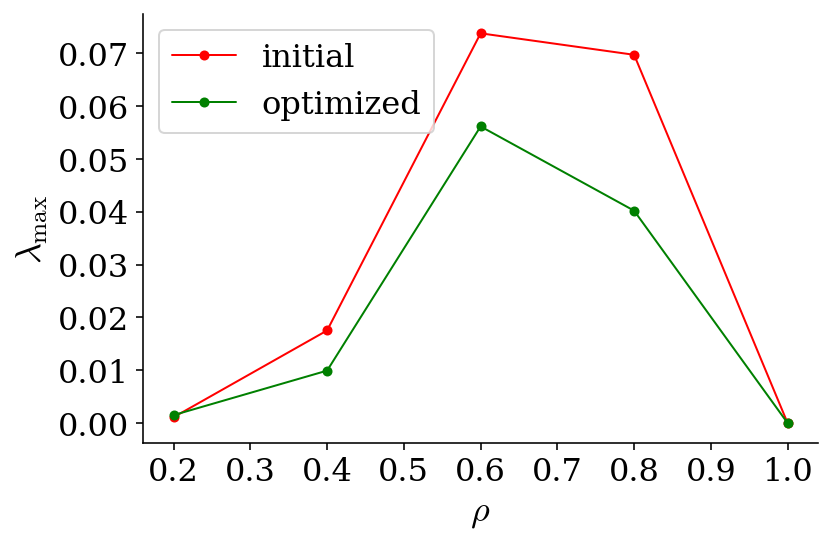

In [57]:
# Flux surfaces on which to evaluate ballooning stability
surfaces = [0.2, 0.4, 0.6, 0.8, 1.0]

grid = LinearGrid(rho = jnp.array(surfaces), NFP=eq.NFP)
eq_data_keys = ["iota"]

data = eq.compute(eq_data_keys, grid=grid)
iota = data["iota"]

Nalpha = int(8) # Number of field lines

# Field lines on which to evaluate ballooning stability
alpha = jnp.linspace(0, np.pi, Nalpha+1)[:Nalpha]

# Number of toroidal transits of the field line 
ntor = int(3)

# Number of point along a field line in ballooning space
N0 = int(1. * ntor * eq.M_grid * eq.N_grid + 1)

# range of the ballooning coordinate zeta
zeta = np.linspace(-jnp.pi*ntor, jnp.pi*ntor, N0)

gamma_max = np.zeros(len(surfaces), )
theta_PEST = np.zeros((N0*Nalpha,))
zeta_full = np.zeros((N0*Nalpha, ))

for j in range(len(surfaces)):
    rho = surfaces[j]*np.ones((N0*Nalpha, ))
    
    for i in range(Nalpha): 
        theta_PEST[N0*i:N0*(i+1)] = alpha[i] + iota[j] * zeta
        zeta_full[N0*i:N0*(i+1)] = zeta
        
    theta_coords = jnp.array([rho, theta_PEST, zeta_full]).T

    
    # Rootfinding theta for a given theta_PEST
    desc_coords = compute_theta_coords(
        eq, theta_coords, L_lmn=eq.L_lmn, tol=1e-8, maxiter=25
    )

    sfl_grid = Grid(desc_coords, sort=False)
    ball_data0 = eq.compute(["ideal_ball_gamma2"], grid=sfl_grid)    

    gamma_max[j] = np.max(ball_data0["ideal_ball_gamma2"])
    print(f"surf number {j} done!")

print("Growth rate calculation finished!")

plt.plot(np.array(surfaces), gamma_max0, '-or', ms=4);
plt.plot(np.array(surfaces), gamma_max, '-og', ms=4);
plt.legend(["initial", "optimized"], fontsize=16)
plt.xlabel(r"$\rho$", fontsize=18);
plt.ylabel(r"$\lambda_{\mathrm{max}}$", fontsize=18);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

# Relation to $\delta\! f$ gyrokinetics

The coefficients used by our ballooning solver are the exact same set used by any $\delta\! f$ gyrokinetic solver. Below we will specify the list and plot seven coefficients used by the GX gyrokinetics solver

$$ \mathrm{gradpar} = \mathbf{b}\cdot \mathbf{\nabla}\zeta $$
$$ g^{aa} = \lvert \mathbf{\nabla} \alpha \rvert^2 $$
$$ g^{ra} = \mathbf{\nabla} \alpha \cdot \mathbf{\nabla} \rho $$
$$ g^{rr} = \lvert \mathbf{\nabla} \rho \rvert^2$$
$$ \mathrm{cvdrift} =  \frac{1}{B^3}[\mathbf{b} \times (\mathbf{b}\cdot \mathbf{\nabla}\mathbf{b})] \cdot \mathbf{\nabla} \alpha = \frac{1}{B^4}[\mathbf{b} \times \left(\mu_0 p + B^2/2\right)] \cdot \mathbf{\nabla} \alpha$$
$$ \mathrm{gbdrift} =  \frac{1}{B^2}(\mathbf{b} \times \mathbf{\nabla}B) \cdot \mathbf{\nabla} \alpha$$
$$ \mathrm{cvdrift_0} = \frac{1}{B^2}(\mathbf{b} \times \mathbf{\nabla}B) \cdot \mathbf{\nabla} \iota$$

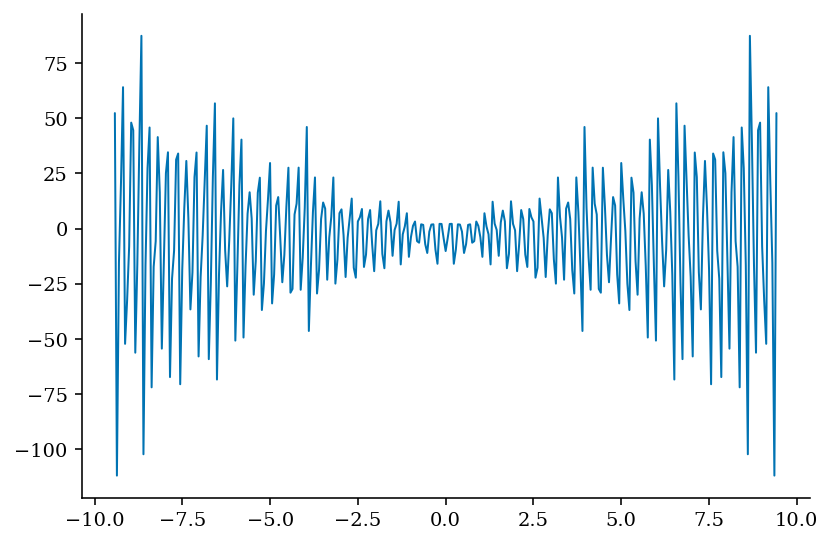

In [58]:
# Calculating the coefficients used by the ballooning solver
plt.plot(zeta,ball_data0["cvdrift"][:N0])